# Monet GAN

<p><strong>Name: </strong>Josiah Ball<br>
<strong>Date: </strong>4/29/2025<br>
<strong>Course: </strong>DTSA 5511</p>

<p>The purpose of this lab is to glorify Jesus Christ by creating a generative adversarial network (GAN) that generates 7,000 to 10,000 Monet-style images, in submission to the <a href="https://www.kaggle.com/competitions/gan-getting-started/overview" target="_blank">"I’m Something of a Painter Myself" Kaggle competition</a> [1]. The intended audience of this project is my fellow students at the University of Colorado at Boulder as well as the Kaggle co-competitors. Due to time constraints, this lab was heavily reliant on ChatGPT for the specific code of the GAN model, though all implementation and model parameter choices were the author's.[2] Comments in model code are author's to display understanding.</p>

<p><strong>NOTE: </strong>I sadly ran out of time on this assignment :( So the model is incomplete. But this notebook reflects my current understanding and as far as I could get into implementing.</p>


## The Problem

<p>The goal of this project is to create a generative adversarial network (GAN) that generates 7,000 to 10,000 Monet-style images as well as accurately determine which images are real and which are fake.</p>

## The Dataset

<p>The training dataset is composed of 300 Monet paintings sized 256x256px, and the testing dataset is made up of 7,028 real photos sized 256x256px to which my 7,028 Monet forgeries will be added.</p>

## Notebook Set Up

<p>Before running exploratory data analysis (EDA), we will initialize the notebook by loading our libraries, ensuring we are running on a GPU (via AWS SageMaker), setting up Kaggle CLI, and downloading our dataset.</p>

In [ ]:
# # Install Libraries if needed
# !pip install kaggle

In [13]:
# Import Libraries
import pandas as pd
import os
import json
import matplotlib.pyplot as plt

import random
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.models import load_model

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # This tells TensorFlow to ignore all GPUs, since I cannot get it to connect properly

In [2]:
# Check GPU Usage
try:
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        raise RuntimeError("🚫 No GPU detected.")
    else:
        print(f"✅ GPU detected: {gpus[0].name}")
except Exception as e:
    print(f"Error: {e}")

Error: 🚫 No GPU detected.


2025-04-29 21:41:00.474969: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-04-29 21:41:00.475014: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: default
2025-04-29 21:41:00.475023: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: default
2025-04-29 21:41:00.475229: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.163.1
2025-04-29 21:41:00.475253: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.163.1
2025-04-29 21:41:00.475259: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.163.1


<p><strong>NOTE: </strong>I could not configure my GPU correctly, so that is why I included <code>os.environ["CUDA_VISIBLE_DEVICES"] = "-1"</code> in order to ignore the existing GPU. This resulted in very slow model training and a limit of 5 epochs per model.</p>

## Upload dataset from Kaggle

In [3]:
# # Create .kaggle folder in home directory
# os.makedirs(Path.home() / ".kaggle", exist_ok=True)

# # Move kaggle.json into the folder and set permissions
# !mv kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [4]:
# # Download dataset
# !kaggle competitions download -c gan-getting-started

In [5]:
# # Unzip dataset
# !unzip -q gan-getting-started.zip -d gan-getting-started

## Exploratory Data Analysis (EDA)

<p>Next, we will run some EDA in order to better understand the dataset before training our model.</p>

<p>Recall from the Kaggle competition that duplicates have already been removed, so we do not have to worry about duplicate removal.</p>

In [6]:
# Define paths
monet_dir = 'gan-getting-started/monet_jpg'
photo_dir = 'gan-getting-started/photo_jpg'

# List the files
monet_images = os.listdir(monet_dir)
photo_images = os.listdir(photo_dir)

print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")

Number of Monet images: 300
Number of Photo images: 7038


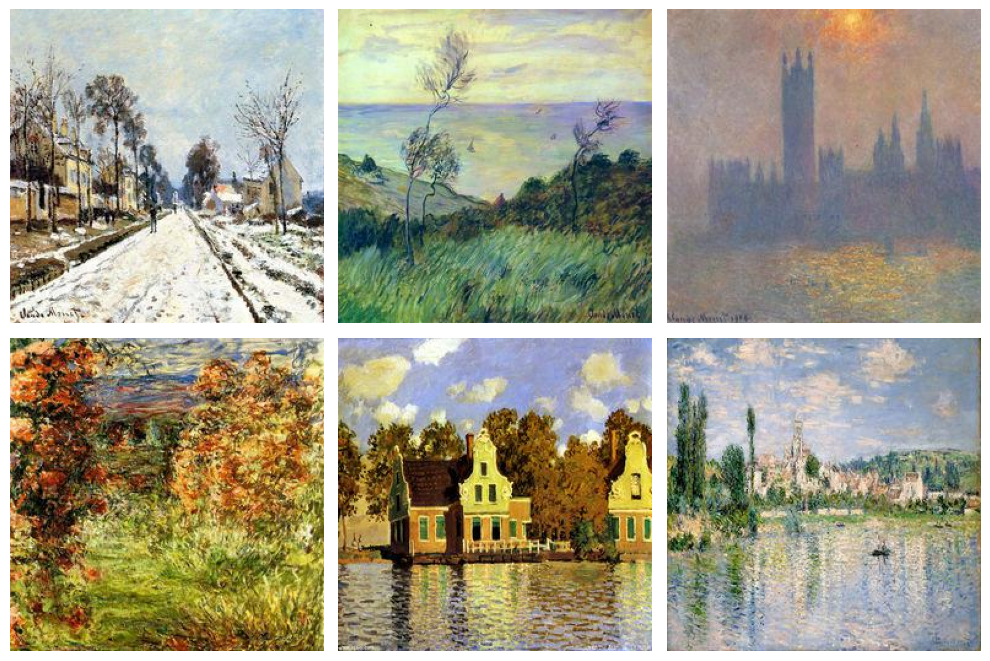

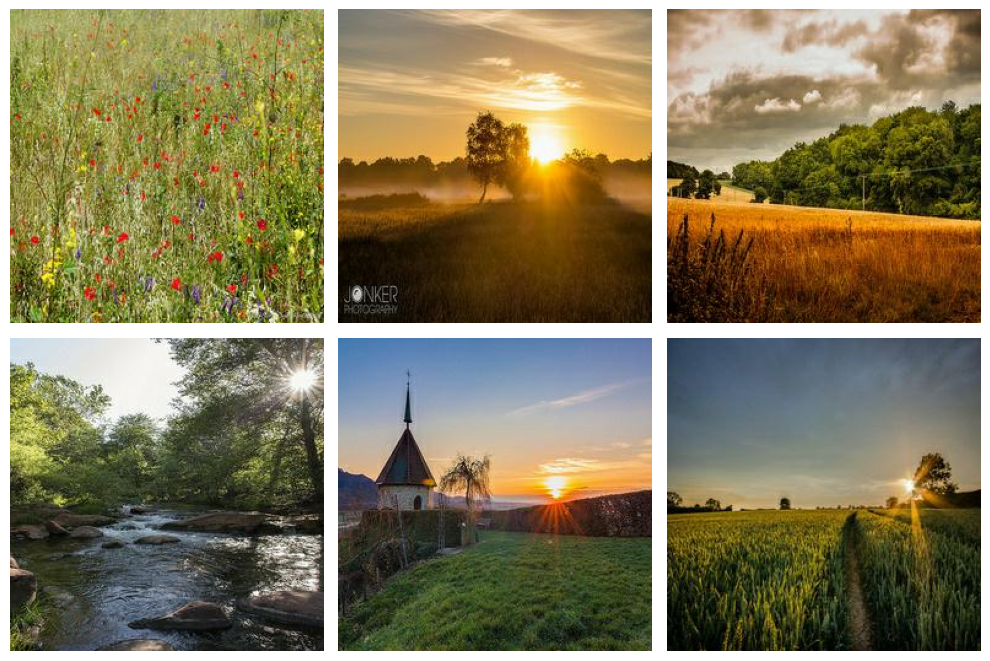

In [7]:
# Inspect the images
def show_images(image_list, image_dir, title, n=6):
    plt.figure(figsize=(10, 10))
    for i in range(n):
        img_name = random.choice(image_list)
        img_path = os.path.join(image_dir, img_name)
        img = Image.open(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot examples
show_images(monet_images, monet_dir, "Monet")
show_images(photo_images, photo_dir, "Photo")

<p><strong>NOTE:</strong> Next, we will normalize the images for better processing in our model.</p>

In [22]:
# Normalize Training/Validation Inputs
batch_size = 32

# Function to load and preprocess image
def load_and_preprocess_image(filepath):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0
    return image

def get_dataset(image_dir):
    filepaths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir)]
    dataset = tf.data.Dataset.from_tensor_slices(filepaths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

monet_ds = get_dataset(monet_dir)
photo_ds = get_dataset(photo_dir)

## Model Training

<p>In this lab, we will our Gan by building two models with the following hyperparameters:</p>

<ul>
    <li>Generator 
        <ul>
            <li>Architecture: Two convolution layers for downsampling, and three layers of transpose convolution layers for upsampling</li>
            <li>Optimizer: Adam</li>
            <li>Encoding, Coding, and Decoding Activation Function: Leaky ReLU</li>
            <li>Regularization: Batch Normalization</li>
            <li>Output Activation Function: tanh</li>
            <li>Loss Function: Binary Cross Entropy</li>
        </ul>
    </li>
    <li>CNN with Dropout and Batch Normalization
        <ul>
            <li>Architecture: Three convolution layers for downsampling, and three layers of transpose convolution layers for upsampling</li>
            <li>Optimizer: Adam</li>
            <li>Encoding, Coding, and Decoding Activation Function: Leaky ReLU</li>
            <li>Regularization: Batch Normalization</li>
            <li>Output: Real or Fake</li>
            <li>Loss Function: Binary Cross Entropy</li>
        </ul>
    </li>
</ul>

### Model 1: Generator

In [16]:
# Build basic generator -- built with help of ChatGPT
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling Convolution Layers
    down0 = layers.Conv2D(32, 4, strides=2, padding='same')(inputs)
    down0 = layers.LeakyReLU()(down0)
    
    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    # Bottleneck Convolution Layer
    bottleneck = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.ReLU()(bottleneck)

    # Upsampling Transpose Convolution Layers
    up1 = layers.Conv2DTranspose(128, 4, strides=2, padding='same')(bottleneck)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.ReLU()(up1)

    up2 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up1)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.ReLU()(up2)

    up3 = layers.Conv2DTranspose(64, 4, strides=2, padding='same')(up2)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.ReLU()(up3)

    # Output Image: 256x256px
    output = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up3)

    return keras.Model(inputs=inputs, outputs=output)

### Model 2: Discriminator

In [17]:
# Build basic discriminator -- built with help of ChatGPT
def build_discriminator():
    input_image = layers.Input(shape=[256, 256, 3], name='input_image')
    target_image = layers.Input(shape=[256, 256, 3], name='target_image')

    # Concatenate input and target images
    x = layers.Concatenate()([input_image, target_image])

    # Downsampling Convolution Layers
    down1 = layers.Conv2D(64, 4, strides=2, padding='same')(x)
    down1 = layers.LeakyReLU()(down1)

    down2 = layers.Conv2D(128, 4, strides=2, padding='same')(down1)
    down2 = layers.BatchNormalization()(down2)
    down2 = layers.LeakyReLU()(down2)

    down3 = layers.Conv2D(256, 4, strides=2, padding='same')(down2)
    down3 = layers.BatchNormalization()(down3)
    down3 = layers.LeakyReLU()(down3)

    down4 = layers.Conv2D(512, 4, strides=2, padding='same')(down3)
    down4 = layers.BatchNormalization()(down4)
    down4 = layers.LeakyReLU()(down4)

    down5 = layers.Conv2D(512, 4, strides=2, padding='same')(down4)
    down5 = layers.BatchNormalization()(down5)
    down5 = layers.LeakyReLU()(down5)

    # Flatten into dense layer and output a single real/fake score
    x = layers.Flatten()(down5)
    output = layers.Dense(1)(x)

    return Model(inputs=[input_image, target_image], outputs=output)

In [18]:
# Create binary cross entropy based loss functions -- built with help of ChatGPT
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    return (real_loss + fake_loss) * 0.5

def generator_loss(fake_output, generated_image, target_image):
    gan_loss = loss_object(tf.ones_like(fake_output), fake_output)
    l1_loss = tf.reduce_mean(tf.abs(target_image - generated_image))
    total_loss = gan_loss + (100 * l1_loss)
    return total_loss

## Model Training

In [14]:
# Build models
generator = build_generator()
discriminator = build_discriminator()

# Define Adam optimizer for both models
gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Create training function
@tf.function
def train_step(input_image, target_image):
    with tf.GradientTape(persistent=True) as tape:
        generated_image = generator(input_image, training=True)

        real_output = discriminator([input_image, target_image], training=True)
        fake_output = discriminator([input_image, generated_image], training=True)

        gen_loss = generator_loss(fake_output, generated_image, target_image)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

## Discussion

<p><strong>Summary: </strong>In this notebook, we:</p>

<ul>
    <li>Overviewed the problem</li>
    <li>Explored the data</li>
    <li>Normalized the data</li>
    <li>Built a generator model</li>
    <li>Built a discriminator model</li>
</ul>

<p><strong>Limitations: </strong>Some of the limitations of this notebook include:</p>

<ul>
    <li>The GPU could not be configured, so we had to run on the CPU</li>
    <li>I ran out of time, so the model was not successfully built or tested</li>
</ul>

<p><strong>Next Steps: </strong>If we were to continue iterating, some possible next steps include:</p>

<ul>
    <li>Complete training the model</li>
    <li>Create images and test score by submitting to Kaggle competition</li>
    <li>Run on a machine with a GPU for faster iteration</li>
    <li>Experiment with differing architectures</li>
</ul>

# Works Cited
[1] Amy Jang, Ana Sofia Uzsoy, and Phil Culliton. I’m Something of a Painter Myself. https://kaggle.com/competitions/gan-getting-started, 2020. Kaggle.<br>
[2] Entire Notebook was completed with the assistance of ChatGPT.